In [1]:
"""
Compare the output of our wind model (Holland, downscaled with local surface roughness)
against the footprints of Done et al. (Willougby with numerical boundary layer simulation)
"""

'\nCompare the output of our wind model (Holland, downscaled with local surface roughness)\nagainst the footprints of Done et al. (Willougby with numerical boundary layer simulation)\n'

In [2]:
import pandas as pd
import geopandas as gpd
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import shapely

import os
from glob import glob

/tmp/ipykernel_868937/4090681641.py:2: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


In [3]:
def grid_point_data(point_speeds: gpd.GeoDataFrame, col_name: str, agg_func_name: str, delta: float = 0.1) -> gpd.GeoDataFrame:
    """
    Bin data on a regular grid. Grid will snap to integer number of `delta` from CRS reference.
    
    Args:
        point_speeds: Table of data at point locations
        col_name: Data column to rebin
        agg_func: Name of function to apply to multiple points within a bin, e.g. max, mean
        delta: Width and height of output raster pixels in decimal degrees
    """
    
    def n_cells(start: float, end: float, width: float) -> int:
        return round((end - start) / width)

    # create grid

    # unpack and snap extrema to integer number of cells from CRS reference
    min_x, min_y, max_x, max_y = map(lambda x: np.ceil(x / delta) * delta, point_speeds.total_bounds)

    cells = []
    for x0 in np.linspace(min_x, max_x, n_cells(min_x, max_x, delta) + 1):
        x1 = x0 + delta
        for y0 in np.linspace(min_y, max_y, n_cells(min_y, max_y, delta) + 1):
            y1 = y0 + delta
            cells.append(shapely.geometry.box(x0, y0, x1, y1))

    grid = gpd.GeoDataFrame({"geometry": cells})

    # associate points with grid
    raster = grid.sjoin(point_speeds, how="inner")

    # take aggregate of arbitrary number of rows (points) grouped by cell
    agg_func = getattr(raster.groupby(raster.index), agg_func_name)
    aggregated = agg_func(col_name)
    
    # merge geometry back in, how="right" for every grid cell, empty or not
    rebinned = aggregated.merge(grid[["geometry"]], left_index=True, right_index=True, how="right")
    rebinned = rebinned.drop(columns=["index_right"])
    
    # cast to GeoDataFrame again (merge reverted to DataFrame) and return
    return gpd.GeoDataFrame(rebinned)

In [4]:
def to_xarray(cells: gpd.GeoDataFrame) -> xr.Dataset:
    """
    Given table of polygon cells, export to xarray
    """
    to_export = cells
    to_export["longitude"] = to_export.geometry.centroid.x
    to_export["latitude"] = to_export.geometry.centroid.y
    to_export = to_export.drop(columns=["geometry"])
    to_export = to_export.set_index(["longitude", "latitude"])
    return to_export.to_xarray()

In [5]:
def read_kw01(name_year: str, delta: float) -> gpd.GeoDataFrame:
    """
    Read the KW01 data, wrangle as points in GeoDataFrame
    
    Args:
        name_year: Storm identifier, e.g. IRMA_2017 or IKE_2008
        delta: Grid resolution to return at in decimal degrees
    """
    
    data = pd.concat(
        [
            pd.read_csv(path, delimiter=r',\s+')
            for path in glob(f"/home/fred/projects/WRN_TC_footprints/footprints/regions/*/{name_year}/*.txt")
        ]
    )
    point_speeds = gpd.GeoDataFrame(
        {
            "max_wind_speed": data["wind(m/s)"],
            "geometry": gpd.points_from_xy(data.lon, data.lat)
        }
    )

    return to_xarray(grid_point_data(point_speeds, "max_wind_speed", "max", delta=delta))

In [6]:
def fig_size(
    min_x: float,
    min_y: float,
    max_x: float,
    max_y: float,
    max_width_in: float = 16,
    max_height_in: float = 9
) -> tuple[float, float]:
    """
    Given bounding box, calculate size of figure in inches for equal aspect ratio.
    
    Returns:
        width in inches, height in inches
    """
    x_span = max_x - min_x
    y_span = max_y - min_y
    aspect_ratio = y_span / x_span
    max_plot_width_in = 16
    max_plot_height_in = 9

    if max_plot_width_in * aspect_ratio < max_plot_height_in:
        # tall
        x_in = max_plot_width_in
        y_in = max_plot_width_in * aspect_ratio

    else:
        # wide
        x_in = max_plot_height_in / aspect_ratio
        y_in = max_plot_height_in
        
    return x_in, y_in

In [7]:
def name_year_from_id(tracks: gpd.GeoDataFrame, storm_id: str) -> str:
    """
    Given IBTrACS storm ID, return name_year.
    e.g. "2017242N16333" -> "IRMA_2017"
    """
    storm_track = tracks[tracks.track_id==storm_id]
    track_point = storm_track.iloc[0]
    name = track_point["name"]
    year = track_point["year"]
    return f"{name}_{year}"

def id_from_name_year(tracks: gpd.GeoDataFrame, name_year: str) -> str | None:
    """
    Given name_year, return IBTrACS storm ID.
    e.g. "IRMA_2017" -> "2017242N16333"
    """
    try:
        name, year = name_year.split("_")
    except ValueError:
        print(f"skipping {name_year}...")
        return None
    track = tracks[(tracks.name==name) & (tracks.year==int(year))]
    try:
        storm_id, = set(track.track_id)
    except ValueError:
        print(f"{name_year} is ambiguous: {set(track.track_id)}, skipping...")
        return None
    return storm_id

In [8]:
def clip_field_to_buffered_points(
    points: gpd.GeoDataFrame,
    field: xr.DataArray,
    buffer_radius_km: float = 0,
) -> xr.Dataset:
    """
    Clip `field` to spatial extent of a buffer around `points`.
    
    Args:
        points: Must include `geometry` column of points.
        field: Longitude latitude data array to clip extent of.
        buffer_radius_km: Only return field within this proximity to points.
    """
    
    # make a buffer around the points
    # N.B. using web mercator as geographic CRS, so extremely wrong for non-tropical latitudes
    points_m = points.to_crs(3857)
    buffer = points_m.buffer(buffer_radius_km * 1000).to_crs(4326)
    
    # get the unary_union of point buffers
    aoi = gpd.GeoDataFrame(geometry=[buffer.unary_union])

    # get the field as geopandas points
    field_pandas = field.to_dataframe().reset_index()
    field_geopandas = gpd.GeoDataFrame(
        {
            field.name: field_pandas[field.name],
            "geometry": gpd.points_from_xy(
                field_pandas.longitude,
                field_pandas.latitude
            )
        }                                
    ).set_crs(4326)

    # find the field values within the AOI 
    clipped_field = field_geopandas.sjoin(aoi, how="inner")[[field.name, "geometry"]].copy()
    
    # recast as xarray field
    #clipped_field.geometry = clipped_field.geometry.drop_duplicates()  # shouldn't be necessary?
    clipped_field["latitude"] = clipped_field.geometry.y
    clipped_field["longitude"] = clipped_field.geometry.x
    clipped_field = clipped_field.drop(columns=["geometry"])
    clipped_field = clipped_field.set_index(["longitude", "latitude"])
    
    return clipped_field.to_xarray()

In [9]:
def plot_error(
    errors: np.ndarray,
    buffer_km: float,
    filepath: str
) -> None:
    """
    Plot distribution of wind speed errors w.r.t Done et al.
    
    pooled_ratio: 1D array of ratios to bin.
    """

    f, ax = plt.subplots(figsize=(8, 5))

    mean = np.nanmean(errors)
    median = np.nanmedian(errors)
    n = len(errors)

    ax.set_title(
        (
            "Wind model validation against Done et al.\n"
            f"for pixels < {buffer_km}km from eye\n"
            f"$n_{{pixels}}={n}, \ \mu={mean:.2f} $ms$^{{-1}}, \ q_{{50}}={median:.2f}$ms$^{{-1}}$"
        ),
        pad=15
    )
    ax.set_xlabel("Errors: downscaled Holland $-$ Done et al. [ms$^{-1}$]", labelpad=10)
    ax.set_ylabel("Frequency", labelpad=10)

    frequency, bin_edges, _ = ax.hist(
        errors,
        bins=np.linspace(-100, 100, 201),
        color="g",
        alpha=0.5,
        density=True,
        label="PDF"
    )

    ax.axvline(mean, color="r", ls="--", label="Mean", alpha=0.5)
    miny, maxy = ax.get_ylim()
    for probability_level in [0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95]:
        quantile = np.quantile(errors, probability_level)
        ax.axvline(quantile, color="pink", ls="--", alpha=0.6)
        ax.text(
            quantile,
            0.07 * maxy,
            f"$\mathrm{{q}}_{{{probability_level:.2f}}}$",
            rotation=-90,
            ha="center",
            size=9
        )

    ax.set_xlim(-20, 20)
    ax.grid(alpha=0.3)
    ax.legend()
    plt.subplots_adjust(top=0.8, bottom=0.15)

    f.savefig(filepath)
    plt.close(f)

In [10]:
def plot_wind_speed_errors(
    name_year: str,
    storm_id: str,
    buffer_km: str,
    holland: xr.Dataset,
    clipped_error: xr.Dataset,
    plot_dir: str,
) -> None:

    model_arr = holland.sel(
        dict(
            longitude=clipped_error.longitude,
            latitude=clipped_error.latitude
        )
    ).max_wind_speed.values.ravel()
    error_arr = clipped_error.error.values.ravel()

    f, (ax_scatter, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
    ax_scatter.scatter(error_arr, model_arr, s=0.1, c="k")
    ax_scatter.set_ylabel("Model wind speed [ms$^{-1}$]")
    ax_scatter.grid(alpha=0.3)
    x_min = -20
    x_max = 20
    ax_scatter.set_xlim(x_min, x_max)
    ax_scatter.axvline(0, color="k", ls="--", alpha=0.8)

    frequency, bin_edges, patches = ax_hist.hist(
        error_arr,
        bins=np.linspace(-50, 50, 150),
        density=True,
        alpha=1,
        color="black"
    )
    
    ax_hist.axvline(0, color="k", ls="--", alpha=0.8)
    ax_hist.set_xlim(x_min, x_max)
    ax_hist.set_ylabel("PDF", labelpad=20)
    ax_hist.set_xlabel("Thomas et al. 2023 - Done et al. 2020 [ms$^{-1}$]")
    ax_hist.spines['top'].set_visible(False)
    ax_hist.spines['right'].set_visible(False)
    ax_hist.spines['left'].set_visible(False)
    ax_hist.get_yaxis().set_ticks([])

    f.suptitle(f"{name_year.replace('_', ' ')} / {storm_id}\nError within {buffer_km}km of eye over land")
    f.savefig(os.path.join(plot_dir, f"{storm_id}_error_distribution.png"))

In [11]:
def plot_wind_speed_maps(
    name_year: str,
    storm_id: str,
    holland: xr.Dataset,
    kw01: xr.Dataset,
    error: xr.Dataset,
    plot_dir: str,
) -> None:

    f, (ax_h, ax_kw, ax_error) = plt.subplots(1, 3, figsize=(12,5))

    vmax = max(holland.max_wind_speed.max(), kw01.max_wind_speed.max()).values
    vmin = min(holland.max_wind_speed.min(), kw01.max_wind_speed.min()).values

    xr.plot.pcolormesh(
        error,
        x="longitude",
        ax=ax_error,
        cbar_kwargs={'label': "Thomas $-$ Done [ms$^{-1}$]"},
    )
    ax_error.set_title("Thomas et al. 2023 - Done et al. 2020")
    xmin, xmax = ax_error.get_xlim()
    ymin, ymax = ax_error.get_ylim()

    xr.plot.pcolormesh(
        holland.max_wind_speed,
        x="longitude",
        ax=ax_h,
        vmax=vmax,
        vmin=vmin,
        cbar_kwargs={'label': "Max wind speed [ms$^{-1}$]"}
    )
    ax_h.set_title("Thomas et al. 2023\nSurface roughness downscaling")
    ax_h.set_xlim(xmin, xmax)
    ax_h.set_ylim(ymin, ymax)

    xr.plot.pcolormesh(
        kw01.max_wind_speed,
        x="longitude",
        ax=ax_kw,
        vmax=vmax,
        vmin=vmin,
        cbar_kwargs={'label': "Max wind speed [ms$^{-1}$]"}
    )
    ax_kw.set_title("Done et al. 2020\nKepert & Wang physical boundary layer")
    ax_kw.set_xlim(xmin, xmax)
    ax_kw.set_ylim(ymin, ymax)

    for ax in (ax_h, ax_kw, ax_error):
        ax.set_xlabel("Longitude")
        ax.set_ylabel("Latitude")

    f.suptitle(f"{name_year.replace('_', ' ')} / {storm_id}")
    plt.subplots_adjust(left=0.05, right=0.9, wspace=0.4, top=0.85, bottom=0.1)
    f.savefig(os.path.join(plot_dir, f"{storm_id}_max_wind_speed_maps.png"))

In [12]:
tracks = gpd.read_parquet(
    "/home/fred/projects/open_gira/open-gira/results/storm_tracks/IBTrACS/tracks.geoparquet"
)
holland_storms_id = {
    path.split("/")[-1] for path in
    glob("/home/fred/projects/open_gira/open-gira/results/power/by_storm_set/IBTrACS/by_storm/*")
}
holland_storms_name_year = {
    name_year_from_id(tracks, storm_id) for storm_id in
    holland_storms_id
}
wrn_storms_name_year = {
    path.split("/")[-2] for path in
    glob(f"/home/fred/projects/WRN_TC_footprints/footprints/regions/*/*/*.txt")
}
common_storms_name_year = holland_storms_name_year & wrn_storms_name_year
common_storms_id = [
    id_from_name_year(tracks, name_year)
    for name_year in common_storms_name_year
]
common_storms = sorted(filter(bool, common_storms_id))

print(f"{len(holland_storms_name_year)=}")
print(f"{len(wrn_storms_name_year)=}")
print(f"{len(common_storms)=}")

skipping NOT_NAMED_2006...
TOMAS_2010 is ambiguous: {'2010069S12188', '2010302N09306'}, skipping...
skipping NOT_NAMED_2011...
skipping NOT_NAMED_2005...
skipping NOT_NAMED_2010...
skipping NOT_NAMED_2017...
skipping NOT_NAMED_2007...
skipping NOT_NAMED_2003...
skipping NOT_NAMED_2014...
skipping NOT_NAMED_2013...
HARVEY_2005 is ambiguous: {'2005215N28291', '2005035S14136'}, skipping...
skipping NOT_NAMED_2016...
JOYCE_2018 is ambiguous: {'2018007S13130', '2018255N37320'}, skipping...
skipping NOT_NAMED_2002...
PODUL_2019 is ambiguous: {'2019237N08140', '2019236N08143'}, skipping...
len(holland_storms_name_year)=1236
len(wrn_storms_name_year)=743
len(common_storms)=586


In [13]:
buffer_km = 200

plot_dir = (
    "/home/fred/projects/open_gira/open-gira/validation/wind_model_comparison/error_by_model_speed"
)
os.makedirs(plot_dir, exist_ok=True)

errors_by_storm = {}
holland_by_storm = {}
kw01_by_storm = {}
for i, storm_id in enumerate(common_storms):

    name_year = name_year_from_id(tracks, storm_id)
    storm_track = tracks[tracks.track_id == storm_id]

    try:
        kw01 = (
            read_kw01(name_year, delta=0.1)
                .interpolate_na(dim="longitude", method="linear")
                .interpolate_na(dim="latitude", method="linear")
        )
        kw01_by_storm[storm_id] = kw01.max_wind_speed
    except ValueError:
        print(f"couldn\'t read kw01 for {name_year}, skipping...")
        continue
        
    try:
        holland = xr.open_dataset(
            (
                "/home/fred/projects/open_gira/open-gira/"
                f"results/power/by_storm_set/IBTrACS/by_storm/{storm_id}/wind_field.nc"
            )
        )
        holland_by_storm[storm_id] = holland.max_wind_speed
    except FileNotFoundError:
        print(f"couldn\'t find holland for {name_year}, skipping...")
        continue

    try:
        error = (holland - kw01).max_wind_speed.rename("error")
        ratio = (holland / kw01).max_wind_speed.rename("ratio")
    except ValueError:
        print(f"couldn\'t calculate the error or ratio for {name_year}, skipping...")
        continue

    # make a buffer around the on-land track      
    print(name_year)
    storm_track_over_land = storm_track[storm_track.landfall == True]
    clipped_error = clip_field_to_buffered_points(storm_track_over_land, error, buffer_km)
    errors_by_storm[storm_id] = clipped_error
    
    
    # don't plot the weak storms (for brevity)
    if storm_track.max_wind_speed_ms.max() < 40:
        print(f"{name_year} has {storm_track.max_wind_speed_ms.max()}, skipping plotting...")
        continue

    #plot_wind_speed_maps(name_year, storm_id, holland, kw01, error, plot_dir)
    #plot_wind_speed_errors(name_year, storm_id, buffer_km, holland, clipped_error, plot_dir)

/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ALLISON_2001
ALLISON_2001 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


YUTU_2001
YUTU_2001 has 38.22004631968363, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TORAJI_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BARRY_2001
BARRY_2001 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PABUK_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DEAN_2001
DEAN_2001 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FITOW_2001
FITOW_2001 has 20.956774554577542, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DANAS_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NARI_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GABRIELLE_2001
GABRIELLE_2001 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LEKIMA_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

IRIS_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAREN_2001
KAREN_2001 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MICHELLE_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LINGLING_2001


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BERNIE_2002
BERNIE_2002 has 26.226606060606056, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TAPAH_2002
TAPAH_2002 has 21.47117455457754, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHRIS_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GUILLAUME_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HARY_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BONNIE_2002
BONNIE_2002 has 26.09995454545454, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KESINY_2002
KESINY_2002 has 37.08940909090909, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NOGURI_2002
NOGURI_2002 has 38.9168371782115, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHATAAN_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RAMMASUN_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HALONG_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NAKRI_2002
NAKRI_2002 has 21.812298946294167, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FENGSHEN_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FUNG-WONG_2002
FUNG-WONG_2002 has 37.696098520219415, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAMMURI_2002
KAMMURI_2002 has 28.903328210230892, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


VONGFONG_2002
VONGFONG_2002 has 25.622069434876895, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RUSA_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SINLAKU_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

EDOUARD_2002
EDOUARD_2002 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FAY_2002
FAY_2002 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAGUPIT_2002
HAGUPIT_2002 has 25.374433639494832, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GUSTAV_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HANNA_2002
HANNA_2002 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ISIDORE_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MEKKHALA_2002
MEKKHALA_2002 has 23.778423809159328, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KYLE_2002
KYLE_2002 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LILI_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HIGOS_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

JULIO_2002
JULIO_2002 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KENNA_2002


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DELFINA_2002
DELFINA_2002 has 28.847318181818178, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FARI_2003
FARI_2003 has 28.847318181818178, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GRAHAM_2003
GRAHAM_2003 has 21.978909090909088, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JAPHET_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CRAIG_2003
CRAIG_2003 has 24.726272727272725, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


INIGO_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MANOU_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LINFA_2003
LINFA_2003 has 28.137470014032402, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SOUDELOR_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CARLOS_2003
CARLOS_2003 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BILL_2003
BILL_2003 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CLAUDETTE_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

IMBUDO_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KONI_2003
KONI_2003 has 32.6474124633244, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ETAU_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MORAKOT_2003
MORAKOT_2003 has 24.169393073096057, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KROVANH_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ERIKA_2003
ERIKA_2003 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


VAMCO_2003
VAMCO_2003 has 20.75984708933963, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IGNACIO_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DUJUAN_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAEMI_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HENRI_2003
HENRI_2003 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ISABEL_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARTY_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LARRY_2003
LARRY_2003 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NORA_2003


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

OLAF_2003
OLAF_2003 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MINDY_2003
MINDY_2003 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MELOR_2003
MELOR_2003 has 30.556493596121953, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NEPARTAK_2003
NEPARTAK_2003 has 35.26281885954841, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CELA_2003
CELA_2003 has 36.47563636363637, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ODETTE_2003
ODETTE_2003 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DEBBIE_2003
DEBBIE_2003 has 35.71572727272727, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ELITA_2004
ELITA_2004 has 35.501393939393935, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FRITZ_2004
FRITZ_2004 has 24.52752727272727, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MONTY_2004


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GAFILO_2004


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NIDA_2004


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CHARLEY_2004


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FRANCES_2004
FRANCES_2004 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ERNEST_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FELAPI_2005
FELAPI_2005 has 20.459090909090907, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


INGRID_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ADRIAN_2005
ADRIAN_2005 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ARLENE_2005
ARLENE_2005 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DORA_2005
DORA_2005 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CINDY_2005
CINDY_2005 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DENNIS_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

EMILY_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAITANG_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BANYAN_2005
BANYAN_2005 has 30.34216026278862, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GERT_2005
GERT_2005 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


WASHI_2005
WASHI_2005 has 23.364474205893607, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MATSA_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

SANVU_2005
SANVU_2005 has 30.118818859548412, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAWAR_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JOSE_2005
JOSE_2005 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KATRINA_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TALIM_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NABI_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KHANUN_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

OPHELIA_2005
OPHELIA_2005 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


VICENTE_2005
VICENTE_2005 has 23.835579364714885, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

RITA_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DAMREY_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LONGWANG_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OTIS_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


STAN_2005
STAN_2005 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

TAMMY_2005
TAMMY_2005 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

WILMA_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ALPHA_2005
ALPHA_2005 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BETA_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAI-TAK_2005


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TEMBIN_2005
TEMBIN_2005 has 23.014352681039245, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BOLAVEN_2005
BOLAVEN_2005 has 33.81906854190585, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GAMMA_2005
GAMMA_2005 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FANOOS_2005
FANOOS_2005 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DARYL_2006
DARYL_2006 has 28.847318181818178, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LARRY_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GLENDA_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MONICA_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MALA_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CHANCHU_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ALBERTO_2006
ALBERTO_2006 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


EWINIAR_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BILIS_2006
BILIS_2006 has 30.23312997065952, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KAEMI_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BERYL_2006
BERYL_2006 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PRAPIROON_2006
PRAPIROON_2006 has 37.39129076412807, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHRIS_2006
CHRIS_2006 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SAOMAI_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARIA_2006
MARIA_2006 has 35.80005483352468, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BOPHA_2006
BOPHA_2006 has 26.537114458476843, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


WUKONG_2006
WUKONG_2006 has 26.251336680699065, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ERNESTO_2006
ERNESTO_2006 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JOHN_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LANE_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

XANGSANE_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PAUL_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CIMARON_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHEBI_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DURIAN_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


UTOR_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BONDO_2006


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NELSON_2007
NELSON_2007 has 27.47363636363636, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FAVIO_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JACOB_2007
JACOB_2007 has 39.429539393939386, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


INDLALA_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KARA_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JAYA_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


AKASH_2007
AKASH_2007 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BARBARA_2007
BARBARA_2007 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GONU_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BARRY_2007
BARRY_2007 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAN-YI_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


USAGI_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PABUK_2007
PABUK_2007 has 34.17686330399285, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SEPAT_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DEAN_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FITOW_2007
FITOW_2007 has 39.62509852021942, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HENRIETTE_2007
HENRIETTE_2007 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FELIX_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

GABRIELLE_2007
GABRIELLE_2007 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NARI_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HUMBERTO_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


WIPHA_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FRANCISCO_2007
FRANCISCO_2007 has 20.66918783518306, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LORENZO_2007
LORENZO_2007 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LEKIMA_2007
LEKIMA_2007 has 34.533512986350296, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KROSA_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NOEL_2007
NOEL_2007 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PEIPAH_2007
PEIPAH_2007 has 39.10595743079474, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SIDR_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HAGIBIS_2007
HAGIBIS_2007 has 39.05354296466386, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MITAG_2007


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OLGA_2007
OLGA_2007 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HELEN_2007
HELEN_2007 has 26.889090909090907, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FAME_2008
FAME_2008 has 38.98918181818182, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IVAN_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JOKWE_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NEOGURI_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NARGIS_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HALONG_2008
HALONG_2008 has 33.31952997065952, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ALMA_2008
ALMA_2008 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FENGSHEN_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KALMAEGI_2008
KALMAEGI_2008 has 38.086277055746905, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CRISTOBAL_2008
CRISTOBAL_2008 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DOLLY_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FUNG-WONG_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAMMURI_2008
KAMMURI_2008 has 26.998593073096053, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


EDOUARD_2008
EDOUARD_2008 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NURI_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FAY_2008
FAY_2008 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JULIO_2008
JULIO_2008 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

GUSTAV_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HANNA_2008
HANNA_2008 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

IKE_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LOWELL_2008
LOWELL_2008 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

SINLAKU_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAGUPIT_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JANGMI_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KYLE_2008
KYLE_2008 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MEKKHALA_2008
MEKKHALA_2008 has 21.94944603138155, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NORBERT_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARCO_2008
MARCO_2008 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ODILE_2008
ODILE_2008 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RASHMI_2008
RASHMI_2008 has 21.43333333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PALOMA_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NOUL_2008
NOUL_2008 has 20.726343390738613, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NISHA_2008
NISHA_2008 has 24.00533333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BILLY_2008


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CHARLOTTE_2009
CHARLOTTE_2009 has 23.34284848484848, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ERIC_2009
ERIC_2009 has 23.34284848484848, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FANELE_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ELLIE_2009
ELLIE_2009 has 20.69290909090909, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IZILDA_2009
IZILDA_2009 has 32.89821818181818, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JADE_2009
JADE_2009 has 33.37754545454545, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BIJLI_2009
BIJLI_2009 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KUJIRA_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHAN-HOM_2009
CHAN-HOM_2009 has 39.130301038397754, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


AILA_2009
AILA_2009 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LINFA_2009
LINFA_2009 has 34.262056907768844, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ANDRES_2009
ANDRES_2009 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NANGKA_2009
NANGKA_2009 has 21.240743390738615, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MOLAVE_2009
MOLAVE_2009 has 37.91994684270953, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GONI_2009
GONI_2009 has 23.65497666794234, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MORAKOT_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BILL_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CLAUDETTE_2009
CLAUDETTE_2009 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KROVANH_2009
KROVANH_2009 has 32.862285526215075, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JIMENA_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KOPPU_2009
KOPPU_2009 has 39.22171055491771, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KETSANA_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PARMA_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MELOR_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PATRICIA_2009
PATRICIA_2009 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RICK_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MIRINAE_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

IDA_2009


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PHYAN_2009
PHYAN_2009 has 24.00533333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAGDA_2010
MAGDA_2010 has 35.93006060606061, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OLGA_2010
OLGA_2010 has 26.18763636363636, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FAMI_2010
FAMI_2010 has 25.05751515151515, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HUBERT_2010
HUBERT_2010 has 28.720666666666666, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ULUI_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PAUL_2010
PAUL_2010 has 37.64472727272727, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LAILA_2010
LAILA_2010 has 29.14933333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JOEL_2010
JOEL_2010 has 33.3190909090909, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


AGATHA_2010
AGATHA_2010 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PHET_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ALEX_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CONSON_2010
CONSON_2010 has 38.90167881617553, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CHANTHU_2010
CHANTHU_2010 has 38.98209852021942, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BONNIE_2010
BONNIE_2010 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DIANMU_2010
DIANMU_2010 has 28.117834685546626, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MINDULLE_2010
MINDULLE_2010 has 29.046612463324404, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


EARL_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LIONROCK_2010
LIONROCK_2010 has 27.474439321342008, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KOMPASU_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MALOU_2010
MALOU_2010 has 25.16538112514351, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HERMINE_2010
HERMINE_2010 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MERANTI_2010
MERANTI_2010 has 32.67172326061998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FANAPI_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KARL_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MATTHEW_2010
MATTHEW_2010 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NICOLE_2010
NICOLE_2010 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PAULA_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MEGI_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GIRI_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RICHARD_2010


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JAL_2010
JAL_2010 has 30.006666666666668, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

TASHA_2010
TASHA_2010 has 21.511272727272726, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BIANCA_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ANTHONY_2011
ANTHONY_2011 has 27.74642424242424, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

YASI_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BINGIZA_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ERROL_2011
ERROL_2011 has 32.383818181818185, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


AERE_2011
AERE_2011 has 22.93580753922694, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SONGDA_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HAIMA_2011
HAIMA_2011 has 20.211943390738615, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BEATRIZ_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ARLENE_2011
ARLENE_2011 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MA-ON_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NOCK-TEN_2011
NOCK-TEN_2011 has 28.627493596121955, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DON_2011
DON_2011 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

EMILY_2011
EMILY_2011 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HARVEY_2011
HARVEY_2011 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NANMADOL_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

IRENE_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TALAS_2011
TALAS_2011 has 29.341938040566397, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LEE_2011
LEE_2011 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARIA_2011
MARIA_2011 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NATE_2011
NATE_2011 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ROKE_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NESAT_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NALGAE_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

JOVA_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RINA_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KEILA_2011
KEILA_2011 has 21.0904, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


WASHI_2011
WASHI_2011 has 25.16538112514351, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GRANT_2011
GRANT_2011 has 30.895175757575757, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


THANE_2011


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHANDA_2012
CHANDA_2012 has 20.653939393939392, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HEIDI_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DANDO_2012
DANDO_2012 has 24.726272727272722, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FUNSO_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IRINA_2012
IRINA_2012 has 30.33790909090909, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LUA_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BUD_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BERYL_2012
BERYL_2012 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GUCHOL_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CARLOTTA_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

TALIM_2012
TALIM_2012 has 26.251336680699065, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DEBBY_2012
DEBBY_2012 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DOKSURI_2012
DOKSURI_2012 has 21.64980753922694, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KHANUN_2012
KHANUN_2012 has 26.765736680699064, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


VICENTE_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SAOLA_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DAMREY_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ERNESTO_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAIKUI_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HELENE_2012
HELENE_2012 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KAI-TAK_2012
KAI-TAK_2012 has 36.91972462048731, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TEMBIN_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ISAAC_2012
ISAAC_2012 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SANBA_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JELAWAT_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NORMAN_2012
NORMAN_2012 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


couldn't calculate the error or ratio for GAEMI_2012, skipping...


/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PAUL_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

SON-TINH_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

SANDY_2012


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NILAM_2012
NILAM_2012 has 24.00533333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


couldn't calculate the error or ratio for SONAMU_2013, skipping...


/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OSWALD_2013
OSWALD_2013 has 21.031945454545454, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PETA_2013
PETA_2013 has 22.48551515151515, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HARUNA_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RUSTY_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ZANE_2013
ZANE_2013 has 34.95581818181818, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAHASEN:VIYARU_2013
MAHASEN:VIYARU_2013 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BARBARA_2013
BARBARA_2013 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ANDREA_2013
ANDREA_2013 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BARRY_2013
BARRY_2013 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BEBINCA_2013
BEBINCA_2013 has 20.92064603138155, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

RUMBIA_2013
RUMBIA_2013 has 30.20878636305651, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SOULIK_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CIMARON_2013
CIMARON_2013 has 20.29193492027044, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JEBI_2013
JEBI_2013 has 29.17998636305651, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MANGKHUT_2013
MANGKHUT_2013 has 22.559061543564233, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

UTOR_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

TRAMI_2013
TRAMI_2013 has 36.54347241995152, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KONG-REY_2013
KONG-REY_2013 has 28.194625569587956, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FERNAND_2013
FERNAND_2013 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JULIETTE_2013
JULIETTE_2013 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TORAJI_2013
TORAJI_2013 has 25.67978112514351, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GABRIELLE_2013
GABRIELLE_2013 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LORENA_2013
LORENA_2013 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

INGRID_2013
INGRID_2013 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAN-YI_2013
MAN-YI_2013 has 33.148063303992856, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MANUEL_2013
MANUEL_2013 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

USAGI_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


WUTIP_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FITOW_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAREN_2013
KAREN_2013 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PHAILIN_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NARI_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OCTAVE_2013
OCTAVE_2013 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KROSA_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SONIA_2013
SONIA_2013 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HAIYAN_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HELEN_2013
HELEN_2013 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LEHAR_2013
LEHAR_2013 has 37.72266666666666, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ALESSIA_2013
ALESSIA_2013 has 23.26490909090909, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHRISTINE_2013


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DELIWE_2014
DELIWE_2014 has 26.012272727272723, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DYLAN_2014
DYLAN_2014 has 29.69490909090909, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

GILLIAN_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HELLEN_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ITA_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BORIS_2014
BORIS_2014 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HAGIBIS_2014
HAGIBIS_2014 has 20.76389642811583, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ARTHUR_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NEOGURI_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

RAMMASUN_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MATMO_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HALONG_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NAKRI_2014
NAKRI_2014 has 27.165825569587955, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BERTHA_2014
BERTHA_2014 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ISELLE_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DOLLY_2014
DOLLY_2014 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ODILE_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KALMAEGI_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FUNG-WONG_2014
FUNG-WONG_2014 has 26.19838248501084, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PHANFONE_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


VONGFONG_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HUDHUD_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TRUDY_2014
TRUDY_2014 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

SINLAKU_2014
SINLAKU_2014 has 25.955504184207168, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAGUPIT_2014


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MEKKHALA_2015
MEKKHALA_2015 has 35.219379653016965, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHEDZA_2015
CHEDZA_2015 has 29.453296969696964, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FUNDI_2015
FUNDI_2015 has 28.720666666666666, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LAM_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARCIA_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NATHAN_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAYSAK_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NOUL_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ANA_2015
ANA_2015 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BLANCA_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CARLOS_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BILL_2015
BILL_2015 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KUJIRA_2015
KUJIRA_2015 has 23.79364779181018, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHAN-HOM_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LINFA_2015
LINFA_2015 has 37.657923727516255, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NANGKA_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HALOLA_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

couldn't calculate the error or ratio for CLAUDETTE_2015, skipping...


/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KOMEN_2015
KOMEN_2015 has 21.43333333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

SOUDELOR_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GONI_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ERIKA_2015
ERIKA_2015 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ETAU_2015
ETAU_2015 has 26.989078083939276, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DUJUAN_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MUJIGAE_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KOPPU_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PATRICIA_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHAPALA_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MEGH_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SANDRA_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MELOR_2015


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


STAN_2016
STAN_2016 has 31.916181818181816, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ROANU_2016
ROANU_2016 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BONNIE_2016
BONNIE_2016 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

COLIN_2016
COLIN_2016 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DANIELLE_2016
DANIELLE_2016 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NEPARTAK_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ABELA_2016
ABELA_2016 has 27.74642424242424, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MIRINAE_2016
MIRINAE_2016 has 28.80424108177063, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NIDA_2016
NIDA_2016 has 36.052876297997194, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


EARL_2016
EARL_2016 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

JAVIER_2016
JAVIER_2016 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHANTHU_2016
CHANTHU_2016 has 27.19392923842327, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DIANMU_2016
DIANMU_2016 has 21.94944603138155, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MINDULLE_2016
MINDULLE_2016 has 34.234018859548414, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LIONROCK_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HERMINE_2016
HERMINE_2016 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NAMTHEUN_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NEWTON_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MERANTI_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MALAKAS_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

JULIA_2016
JULIA_2016 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MEGI_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CHABA_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MATTHEW_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


AERE_2016
AERE_2016 has 29.131950432453117, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

SARIKA_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HAIMA_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OTTO_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TOKAGE_2016
TOKAGE_2016 has 28.25178112514351, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NADA_2016
NADA_2016 has 21.43333333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

VARDAH_2016
VARDAH_2016 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NOCK-TEN_2016


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DINEO_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ALFRED_2017
ALFRED_2017 has 26.889090909090907, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BLANCHE_2017
BLANCHE_2017 has 29.706599999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ENAWO_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DEBBIE_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAARUTHA_2017
MAARUTHA_2017 has 22.290666666666667, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MORA_2017
MORA_2017 has 34.29333333333334, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

BEATRIZ_2017
BEATRIZ_2017 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MERBOK_2017
MERBOK_2017 has 28.289841081770632, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CALVIN_2017
CALVIN_2017 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BRET_2017
BRET_2017 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CINDY_2017
CINDY_2017 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NANMADOL_2017
NANMADOL_2017 has 30.98516026278862, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TALAS_2017
TALAS_2017 has 26.251336680699065, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NORU_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SONCA_2017
SONCA_2017 has 21.337811591614578, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NESAT_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAITANG_2017
HAITANG_2017 has 22.806779364714885, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

EMILY_2017
EMILY_2017 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FRANKLIN_2017
FRANKLIN_2017 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

HARVEY_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HATO_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PAKHAR_2017
PAKHAR_2017 has 30.976152192881745, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

IRMA_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LIDIA_2017
LIDIA_2017 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MAWAR_2017
MAWAR_2017 has 25.736936680699063, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KATIA_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TALIM_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DOKSURI_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MAX_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARIA_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PILAR_2017
PILAR_2017 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NATE_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

KHANUN_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LAN_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DAMREY_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAI-TAK_2017
KAI-TAK_2017 has 23.236587830080367, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TEMBIN_2017


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HILDA_2017
HILDA_2017 has 27.34893333333333, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KELVIN_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


MARCUS_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ELIAKIM_2018
ELIAKIM_2018 has 32.60594545454545, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NORA_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

ALBERTO_2018
ALBERTO_2018 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


EWINIAR_2018
EWINIAR_2018 has 20.935363094782495, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BUD_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GAEMI_2018
GAEMI_2018 has 21.469365612960836, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

CARLOTTA_2018
CARLOTTA_2018 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PRAPIROON_2018
PRAPIROON_2018 has 37.5299454828422, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MARIA_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BERYL_2018
BERYL_2018 has 36.007999999999996, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


couldn't calculate the error or ratio for SON-TINH_2018, skipping...


/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


AMPIL_2018
AMPIL_2018 has 26.960039321342006, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

JONGDARI_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SHANSHAN_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


YAGI_2018
YAGI_2018 has 22.497593073096056, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BEBINCA_2018
BEBINCA_2018 has 27.48438248501084, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LEEPI_2018
LEEPI_2018 has 27.027170850873834, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


RUMBIA_2018
RUMBIA_2018 has 24.30804779181018, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SOULIK_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


CIMARON_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


JEBI_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FLORENCE_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OLIVIA_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

GORDON_2018
GORDON_2018 has 30.863999999999997, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MANGKHUT_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BARIJAT_2018
BARIJAT_2018 has 21.94944603138155, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TRAMI_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ROSA_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KONG-REY_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


SERGIO_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LUBAN_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MICHAEL_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


TITLI_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

TARA_2018
TARA_2018 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


VICENTE_2018
VICENTE_2018 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

WILLA_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


YUTU_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

USAGI_2018
USAGI_2018 has 35.64804631968363, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


GAJA_2018
GAJA_2018 has 37.72266666666666, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


OWEN_2018


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PHETHAI_2018
PHETHAI_2018 has 28.291999999999998, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PENNY_2018
PENNY_2018 has 28.75963636363636, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DESMOND_2019
DESMOND_2019 has 21.031945454545454, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

TREVOR_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


VERONICA_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KENNETH_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FANI_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

couldn't read kw01 for ANN_2019, skipping...


/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BARRY_2019
BARRY_2019 has 33.436, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DANAS_2019
DANAS_2019 has 23.321179364714887, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


WIPHA_2019
WIPHA_2019 has 23.835579364714885, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FRANCISCO_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LEKIMA_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KROSA_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BAILU_2019
BAILU_2019 has 29.475279129991073, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

DORIAN_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FAXAI_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


LINGLING_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

FERNAND_2019
FERNAND_2019 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

LORENA_2019
LORENA_2019 has 38.58, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


IMELDA_2019
IMELDA_2019 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAREN_2019
KAREN_2019 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

MITAG_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NARDA_2019
NARDA_2019 has 23.148, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HAGIBIS_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

NESTOR_2019
NESTOR_2019 has 25.72, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path,

PRISCILLA_2019
PRISCILLA_2019 has 20.576, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


NAKRI_2019
NAKRI_2019 has 34.94272150019135, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KALMAEGI_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


KAMMURI_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BELNA_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


PHANFONE_2019


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


BLAKE_2020
BLAKE_2020 has 25.06530909090909, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


FRANCISCO_2020
FRANCISCO_2020 has 23.440272727272724, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


DAMIEN_2020


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


ESTHER_2020
ESTHER_2020 has 23.779309090909088, skipping plotting...


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)
/tmp/ipykernel_868937/987684252.py:12: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  pd.read_csv(path, delimiter=r',\s+')


HEROLD_2020


/home/fred/micromamba/envs/open-gira/lib/python3.10/site-packages/geopandas/geodataframe.py:2061: UserWarning: CRS mismatch between the CRS of left geometries and the CRS of right geometries.
Use `to_crs()` to reproject one of the input geometries to match the CRS of the other.

Left CRS: EPSG:4326
Right CRS: None

  return geopandas.sjoin(left_df=self, right_df=df, *args, **kwargs)


In [14]:
model = []
error = []
for storm_id, clipped_error in errors_by_storm.items():
    holland = holland_by_storm[storm_id]

    try:
        model_arr = holland.sel(
            dict(
                longitude=clipped_error.longitude,
                latitude=clipped_error.latitude
            ),
            method="nearest",
            tolerance=1E-3
        ).values.ravel()
        error_arr = clipped_error.error.values.ravel()
        print(storm_id, model_arr.shape, error_arr.shape)
    except ValueError:
        print(storm_id, "cannot retrieve model data")

    if len(model_arr) == len(error_arr) and len(model_arr) != 0:
        model.append(model_arr)
        error.append(error_arr)
        
pooled_model = np.concatenate(model)
pooled_error = np.concatenate(error)

2001157N28265 (104,) (104,)
2001204N19127 cannot retrieve model data
2001206N14134 (220,) (220,)
2001215N26275 (144,) (144,)
2001225N18146 (1620,) (1620,)
2001235N18296 cannot retrieve model data
2001239N19116 (693,) (693,)
2001246N19156 (936,) (936,)
2001248N23125 (810,) (810,)
2001255N26276 (285,) (285,)
2001264N21126 (285,) (285,)
2001278N12302 (144,) (144,)
2001284N28297 (399,) (399,)
2001303N13276 (408,) (408,)
2001309N10130 (1029,) (1029,)
2001365S12138 cannot retrieve model data
2002008N07141 (378,) (378,)
2002033S13121 (528,) (528,)
2002045S18049 cannot retrieve model data
2002063S11066 (266,) (266,)
2002098S07133 (252,) (252,)
2002122S07063 (80,) (80,)
2002155N20112 cannot retrieve model data
2002178N04155 (425,) (425,)
2002178N10139 (220,) (220,)
2002187N11160 cannot retrieve model data
2002189N21116 (198,) (198,)
2002195N11172 cannot retrieve model data
2002200N21150 cannot retrieve model data
2002214N19120 (315,) (315,)
2002227N14115 (338,) (338,)
2002234N14164 (462,) (462,

2010267N14285 (2325,) (2325,)
2010271N19276 (390,) (390,)
2010284N14278 (888,) (888,)
2010285N13145 (1353,) (1353,)
2010293N17093 cannot retrieve model data
2010293N17277 (726,) (726,)
2010305N06105 (375,) (375,)
2010358S13152 (1085,) (1085,)
2011021S16129 (1225,) (1225,)
2011023S16147 cannot retrieve model data
2011028S13180 (1938,) (1938,)
2011038S11062 (2640,) (2640,)
2011103S12126 (406,) (406,)
2011126N11129 (1634,) (1634,)
2011140N08142 (442,) (442,)
2011167N08129 (1127,) (1127,)
2011170N12263 cannot retrieve model data
2011179N20267 (552,) (552,)
2011192N18158 (814,) (814,)
2011205N12130 (2184,) (2184,)
2011208N22274 (143,) (143,)
2011214N15299 (189,) (189,)
2011231N15278 (2640,) (2640,)
2011233N12129 (1408,) (1408,)
2011233N15301 (5780,) (5780,)
2011236N15143 (700,) (700,)
2011245N27269 (360,) (360,)
2011250N12324 cannot retrieve model data
2011250N20266 (240,) (240,)
2011253N20145 (1176,) (1176,)
2011266N13139 (2639,) (2639,)
2011270N18139 (2584,) (2584,)
2011279N10257 (117,) (

2019074S08151 (4340,) (4340,)
2019077S13123 cannot retrieve model data
2019112S10053 (640,) (640,)
2019116N02090 (940,) (940,)
2019192N29274 (1440,) (1440,)
2019195N13136 (960,) (960,)
2019210N16117 (1254,) (1254,)
2019213N17155 (1353,) (1353,)
2019214N15134 (1260,) (1260,)
2019216N16147 (640,) (640,)
2019231N13135 (442,) (442,)
2019236N10314 (912,) (912,)
2019242N14180 (589,) (589,)
2019243N06136 (1024,) (1024,)
2019246N24266 (357,) (357,)
2019260N12262 (1632,) (1632,)
2019261N28264 (81,) (81,)
2019265N12301 cannot retrieve model data
2019268N10155 (620,) (620,)
2019272N14261 (3248,) (3248,)
2019278N16165 (714,) (714,)
2019291N22264 (1575,) (1575,)
2019293N17257 (247,) (247,)
2019308N13114 (578,) (578,)
2019314N14136 (1204,) (1204,)
2019329N09160 (561,) (561,)
2019336S06055 (1332,) (1332,)
2019354N05151 cannot retrieve model data
2020004S14122 (2256,) (2256,)
2020034S13063 (396,) (396,)
2020034S17129 (1610,) (1610,)
2020052S13140 (4104,) (4104,)
2020072S14054 cannot retrieve model dat

Text(0.5, 0.98, 'Wind model comparison (error within 200km of eye over land)\n$n_{pixels}=442728, \\ \\mu=0.35 $ms$^{-1}, \\ q_{50}=0.22$ms$^{-1}$')

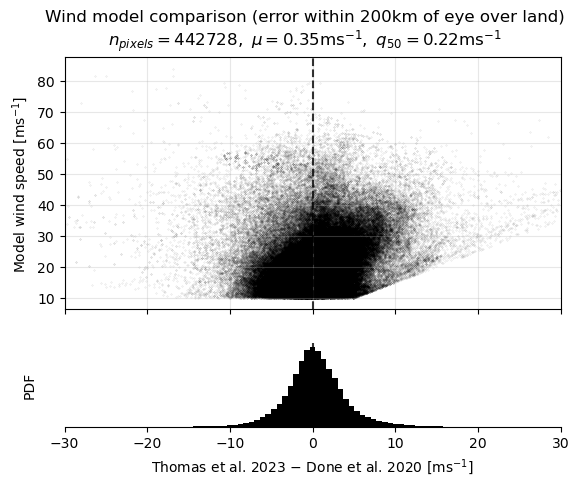

In [15]:
vmin = 10
vmax = 90

df = pd.DataFrame({"error": pooled_error, "model": pooled_model})
df = df[df.model > vmin]

f, (ax_scatter, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

stride = 1
ax_scatter.scatter(
    df.error[::stride],
    df.model[::stride],
    s=0.05,
    c="k",
    alpha=0.2
)
ax_scatter.set_ylabel("Model wind speed [ms$^{-1}$]")
ax_scatter.grid(alpha=0.3)
x_min = -30
x_max = 30
ax_scatter.set_xlim(x_min, x_max)
ax_scatter.axvline(0, color="k", ls="--", alpha=0.8)

frequency, bin_edges, patches = ax_hist.hist(
    df.error,
    bins=np.linspace(-50, 50, 150),
    density=True,
    alpha=1,
    color="black"
)
ax_hist.axvline(0, color="k", ls="--", alpha=0.8)
ax_hist.set_xlim(x_min, x_max)
ax_hist.set_ylabel("PDF", labelpad=20)
ax_hist.set_xlabel("Thomas et al. 2023 $-$ Done et al. 2020 [ms$^{-1}$]")
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['left'].set_visible(False)
ax_hist.get_yaxis().set_ticks([])

n = len(df)
mean = df.error.mean()
median = df.error.median()

f.suptitle(
    f"Wind model comparison (error within {buffer_km}km of eye over land)\n"
    f"$n_{{pixels}}={n}, \ \mu={mean:.2f} $ms$^{{-1}}, \ q_{{50}}={median:.2f}$ms$^{{-1}}$"
)

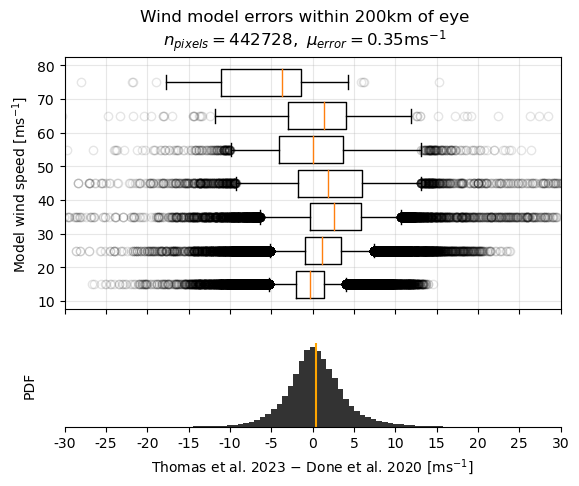

In [18]:
vmin = 10
vmax = 80

df = pd.DataFrame({"error": pooled_error, "model": pooled_model})
df = df[df.model > vmin]

f, (ax_box, ax_hist) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})

ax_box.set_ylabel("Model wind speed [ms$^{-1}$]")
ax_box.grid(alpha=0.3)
xticks = np.linspace(-30, 30, 13) 
ax_box.set_xticks(xticks, labels=[f"{int(x):d}" for x in xticks])

step = 10
speed_bands = np.linspace(vmin, vmax, int((vmax - vmin) / step + 1))
errors_by_band = []
for i, lower_bound in enumerate(speed_bands[:-1]):
    upper_bound = speed_bands[i + 1]
    mid_point = (lower_bound + upper_bound) / 2
    span = upper_bound - lower_bound
    band_errors = df.loc[df.model.between(lower_bound, upper_bound), "error"]
    # boxplot routine can't handle NaN values, mask them out
    errors_by_band.append(band_errors[~np.isnan(band_errors)])
    
ax_box.boxplot(
    errors_by_band,
    vert=False,
    positions=speed_bands[:-1] + step / 2,
    widths=[step * 0.8] * len(errors_by_band),
    whis=[5, 95],  # percentiles
    flierprops=dict(alpha=0.1)
)
yticks = [10, 20, 30, 40, 50, 60, 70, 80]
ax_box.set_yticks(yticks, labels=yticks)

n = len(df)
mean = df.error.mean()

frequency, bin_edges, patches = ax_hist.hist(
    df.error,
    bins=np.linspace(-50, 50, 150),
    density=True,
    alpha=0.8,
    color="black"
)
ax_hist.set_xlim(x_min, x_max)
ax_hist.set_ylabel("PDF", labelpad=20)
ax_hist.set_xlabel("Thomas et al. 2023 $-$ Done et al. 2020 [ms$^{-1}$]")
ax_hist.spines['top'].set_visible(False)
ax_hist.spines['right'].set_visible(False)
ax_hist.spines['left'].set_visible(False)
ax_hist.get_yaxis().set_ticks([])
ax_hist.axvline(mean, color="orange", lw=1.5)

f.suptitle(
    f"Wind model errors within {buffer_km}km of eye\n"
    f"$n_{{pixels}}={n}, \ \mu_{{error}}={mean:.2f} $ms$^{{-1}}$"
)

f.savefig(
    os.path.join(
        "/home/fred/projects/open_gira/open-gira/validation/wind_model_comparison/",
        "thomas_vs_done.png"
    )
)